<a href="https://colab.research.google.com/github/pollyjuice74/LDPC-codes/blob/main/quintuple_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SKIP THIS SECTION**

In [26]:
# Import TensorFlow and NumPy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

In [27]:
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, GaussianPriorSource
from sionna.utils import BinarySource, ebnodb2no, BitwiseMutualInformation, hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER
from sionna.mapping import Mapper, Demapper
from sionna.channel import AWGN
from sionna.fec.ldpc import LDPCBPDecoder
from sionna.fec.linear import OSDecoder

from tensorflow.keras.layers import Dense, Layer

import torch
import torch.nn as nn


---

# In the following cells there is the implementation for a quintuple decoder and a plot of the Bit Error Rates with the Error Probabilities.

---



In [43]:
############################################################
### READ THE COMMENTS IF YOU DON'T WANT TO READ THE CODE ###
############################################################

# This cell just GENERATES the DATA


n = 10 # number of bits sent
err_prob = 0.3 # error probability
rep = 5 # ammount of times a bit will be repeated

def generate_data(n, err_prob):
  # Create random bits and repeat 5 times
  bits = np.random.randint(0, 2, size=n)
  repeat_bits = np.repeat(bits, rep)

  # Create noise with a given error probability
  noise = np.random.rand(n*rep) < err_prob
  noisy_bits = np.logical_xor(repeat_bits, noise).astype(int)

  # Return "recieved" repeated noisy bits, and original bits sent
  return torch.tensor(noisy_bits, dtype=float), torch.tensor(bits)


# Call generate data function
noisy_bits, bits = generate_data(n, err_prob)

# Example data
bits, noisy_bits

(tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1]),
 tensor([1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
         1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
         1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
        dtype=torch.float64))

In [44]:
# This cell is for DECODING using majority voting system


def decode_bits(noisy_bits, original_bits):
  # Reshape the noisy bits recieved to (num bits sent, quintuple repetitions) shaped tensor
  noisy_bits = noisy_bits.reshape(-1, rep)

  # Calculate the mean of the repetitions
  decoded_bits = torch.mean(noisy_bits, axis=1).round().to(torch.int32)

  # Calculate Bit Error Rate
  error = torch.sum(decoded_bits != original_bits)
  ber = error / n

  return decoded_bits, ber


# Call decoding function
decoded_bits, ber = decode_bits(noisy_bits, bits)

# Example data
decoded_bits.shape, ber

(torch.Size([10]), tensor(0.2000))

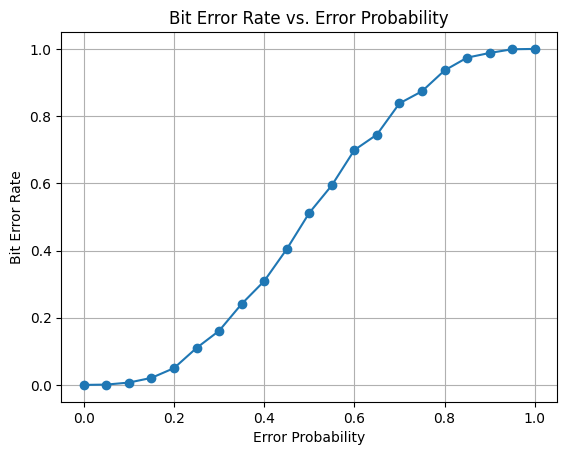

In [45]:
# This cell calculates Bit Error Rates given Error Probabilities and plots them in a graph


error_probs = np.arange(0, 1.05, 0.05) # List of Error Probabilityies as x coordinate
ber_values = [] # List of Bit Error Rates as the y coordinate
n = 100000 # Number of sent bits

# Loop to calculate the BER for each error probability
for error_prob in error_probs:
    # Generate random bits and noisy recieved bits
    noisy_bits, original_bits = generate_data(n, error_prob)
    # Decodes recieved bits and calculates BER
    decoded_bits, ber = decode_bits(noisy_bits, original_bits)
    ber_values.append(ber)

# Plotting
plt.plot(error_probs, ber_values, marker='o')
plt.title('Bit Error Rate vs. Error Probability')
plt.xlabel('Error Probability')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.show()